# RAGAS Results

In [2]:
import pandas as pd
import re
import json
import math
import matplotlib.pyplot as plt

# Accuracy Evaluation

In [2]:
def evaluate_accuracy(responses):
    """
    Evaluate the model's responses and calculate accuracy, while also tracking incorrect question indices.
    """
    correct_count = 0  # Track the number of correct responses
    none_count = 0  # Track the number of 'None' responses
    incorrect_questions = []  # Track the indices of incorrect questions

    for index, question_data in enumerate(responses):
        evaluation_result = evaluate_model_response(question_data['response'], question_data)
        
        if evaluation_result == 1:
            correct_count += 1  # Increment for correct response
        elif evaluation_result is None:
            none_count += 1  # Increment for None response
            incorrect_questions.append(index)  # Add index to incorrect list
        else:
            incorrect_questions.append(index)  # Add index to incorrect list

    # Calculate accuracy
    accuracy = correct_count / len(responses) * 100
    return accuracy, none_count, incorrect_questions

def evaluate_model_response(model_response, question_data):
    """
    Compare the model's response with the correct answer from the question data.
    
    Parameters:
    - model_response: The response string generated by the model.
    - question_data: Dictionary containing the question, options, and the correct answer.

    Returns:
    - 1 if the response is correct, otherwise the extracted model option.
    """
    correct_option = extract_option(question_data['answer'])  # Extract correct option
    relevant_response = extract_response_after_assistant(model_response)  # Get relevant part of response
    model_option = extract_option(relevant_response)  # Extract model's option

    return 1 if model_option == correct_option else model_option  # Return 1 if correct, else model's option

def extract_response_after_assistant(response):
    """
    Extract the part of the response that comes after the 'assistant' marker.

    Parameters:
    - response: The complete response from the model.

    Returns:
    - String: The extracted relevant part of the response.
    """
    # Split the response based on the 'assistant' marker
    parts = response.split('assistant', 1)
    # Return the part after 'assistant' or the entire response if 'assistant' is not found
    return parts[1].strip() if len(parts) > 1 else response.strip()

def extract_option(answer):
    """
    Extract the option part from the answer string, removing all punctuation and converting to lowercase.
    
    Parameters:
    - answer: A string containing the answer in the format 'option X: ...'.

    Returns:
    - String: Extracted option (e.g., 'option 2'), or None if no match is found.
    """
    # Remove all punctuation and convert to lowercase
    cleaned_answer = re.sub(r'[^\w\s]', '', answer.lower())
    # Find all matches for the format "option X"
    matches = re.findall(r'option \d+', cleaned_answer)
    # Return the last match with stripped whitespace if any found, otherwise None
    return matches[-1].strip() if matches else None

def calculate_confidence_interval(accuracy, sample_size, confidence_level=0.95):
    """
    Calculate the confidence interval for a given accuracy and sample size.
    
    :param accuracy: Accuracy as a percentage (0-100).
    :param sample_size: Number of samples used to compute accuracy.
    :param confidence_level: Confidence level (default is 0.95 for 95% confidence).
    :return: Tuple (lower_bound, upper_bound) of the confidence interval.
    """
    accuracy_proportion = accuracy / 100
    z = 1.96 if confidence_level == 0.95 else 1.64  # Default: 95% confidence
    std_error = math.sqrt((accuracy_proportion * (1 - accuracy_proportion)) / sample_size)
    lower_bound = accuracy_proportion - z * std_error
    upper_bound = accuracy_proportion + z * std_error
    return max(0, lower_bound), min(1, upper_bound)

# Function to evaluate models and calculate confidence intervals
def evaluate_and_calculate_intervals(models):
    """
    Evaluate accuracy for all models and calculate their confidence intervals.
    
    :param models: Dictionary with model names as keys and their responses as values.
    :return: Dictionary with evaluation results and confidence intervals for each model.
    """
    results = {}
    for model_name, responses in models.items():
        # Evaluate model accuracy
        accuracy, none_count, incorrect_questions = evaluate_accuracy(responses)
        sample_size = len(responses)
        
        # Calculate confidence interval
        confidence_interval = calculate_confidence_interval(accuracy, sample_size)
        
        # Store results
        results[model_name] = {
            "accuracy": accuracy,
            "confidence_interval": confidence_interval,
            "sample_size": sample_size,
            "none_count": none_count
        }
    return results

In [5]:
responses_path = "files/responses/llama_3.2_lora_short_answer_rag_responses.json"
with open(responses_path, "r") as file:
    llama_3_2_lora_rag = json.load(file)

In [6]:
models = {
    "RAG llama 3.2 3B Lora": llama_3_2_lora_rag
}

In [7]:
# Evaluate models and calculate confidence intervals
evaluation_results = evaluate_and_calculate_intervals(models)

# Display results
print("\nSummary of all models' accuracy with confidence intervals:")
for model_name, result in evaluation_results.items():
    lower, upper = result["confidence_interval"]
    print(f"{model_name} - Accuracy: {result['accuracy']:.2f}%, Confidence Interval: [{lower:.4f}, {upper:.4f}], Sample Size: {result['sample_size']}, 'None' responses: {result['none_count']}")


Summary of all models' accuracy with confidence intervals:
RAG llama 3.2 3B Lora - Accuracy: 76.00%, Confidence Interval: [0.6763, 0.8437], Sample Size: 100, 'None' responses: 0


# LLM Evaluation 

In [8]:
# Load the data from CSV files
llama_3_2_lora_rag_ragas_llm = pd.read_csv("files/evaluations/llama_3_2_lora_short_answer_rag_evaluation_ragas_llm.csv")

In [9]:
# Calculate means of each DataFrame's columns
means_llama_3_2_lora_rag_ragas_llm = llama_3_2_lora_rag_ragas_llm.mean(numeric_only=True)

# Combine means into a comparative table
model_means = pd.DataFrame({
    "RAG llama 3.2 3B Lora": means_llama_3_2_lora_rag_ragas_llm
}).T  # Transpose to have models as rows and metrics as columns

# Round for better readability
model_means = model_means.round(3)

In [10]:
print("Model Performance with LLM evaluation:")
model_means

Model Performance with LLM evaluation:


,Unnamed: 0,factual_correctness(mode=f1),semantic_similarity,answer_relevancy
RAG llama 3.2 3B Lora,49.5,0.135,0.426,0.431


# No LLM Evaluation 

In [12]:
llama_3_2_lora_rag_ragas_no_llm = pd.read_csv("files/evaluations/llama_3_2_lora_short_answer_rag_evaluation_ragas_no_llm.csv")

In [14]:
# Calculate means of each DataFrame's columns
means_llama_3_2_lora_rag_ragas_no_llm = llama_3_2_lora_rag_ragas_no_llm.mean(numeric_only=True)

# Combine means into a comparative table
model_means = pd.DataFrame({
    "RAG llama 3.2 3B Lora": means_llama_3_2_lora_rag_ragas_no_llm,
}).T  # Transpose to have models as rows and metrics as columns

# Round for better readability
model_means = model_means.round(3)

In [15]:
print("Model Performance without LLM evaluation:")
model_means

Model Performance without LLM evaluation:


,Unnamed: 0,bleu_score,rouge_score(mode=fmeasure),exact_match,string_present
RAG llama 3.2 3B Lora,49.5,0.106,0.232,0.05,0.05


# Visualization

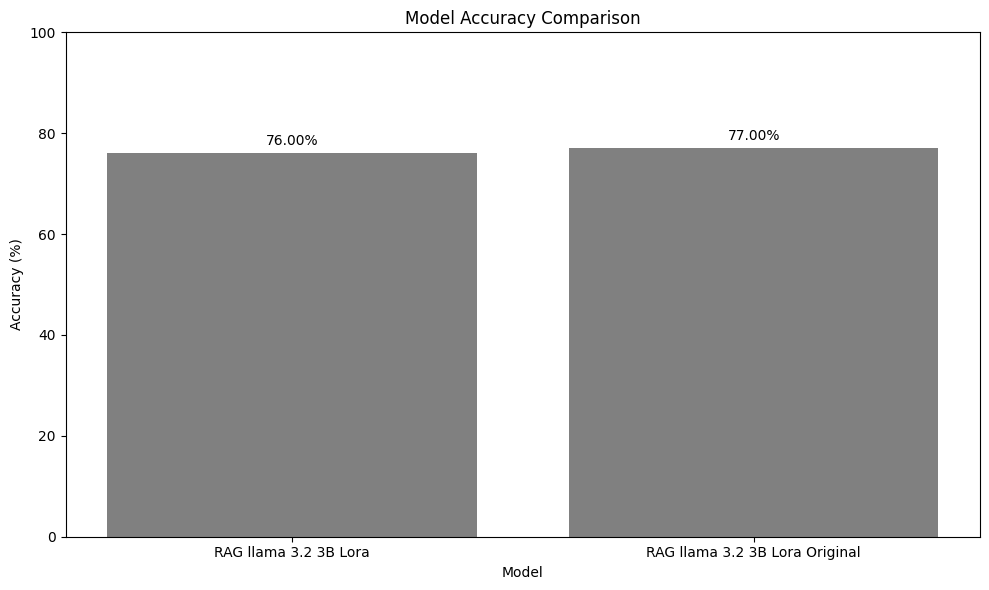

In [6]:
"""
Plot a bar chart comparing the accuracies of different models, with all bars in gray.
"""
# Extract model names and their accuracies
model_names = ["RAG llama 3.2 3B Lora", "RAG llama 3.2 3B Lora Original"]
accuracies = [76.00, 77.00]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='gray')  # Set all bars to gray

# Add labels and title
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100%

# Display values above bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 1, f"{accuracy:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=0, ha='center')  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to fit all elements

# Show the plot
plt.show()

In [8]:
data_visualization = [
    ['RAG llama 3.2 3B Lora', 0.135, 0.426, 'N/A', 0.431],
    ['RAG llama 3.2 3B Lora Original', 0.180, 0.410, 1.81, 'N/A']
]
df_visualization = pd.DataFrame(data_visualization, columns=['Model', 'Factual Correctness', 'Semantic Similarity', 'Rubrics Score with Reference', 'Answer Relevancy'])
df_visualization

,Model,Factual Correctness,Semantic Similarity,Rubrics Score with Reference,Answer Relevancy
0,RAG llama 3.2 3B Lora,0.135,0.426,N/A,0.431
1,RAG llama 3.2 3B Lora Original,0.180,0.410,1.81,N/A
